In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from model import MultimodalRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tools import plot_loss_function, model_comparison
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import os
import json
import optuna

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
X_train_text = np.load("data/X_train_text_tri.npy", allow_pickle=True)
X_test_text = np.load("data/X_test_text_tri.npy", allow_pickle=True)
train = pd.read_csv('data/train_preprocessed.csv')
test = pd.read_csv('data/test_preprocessed.csv')

In [3]:
y_train = train['SalaryNormalized']
y_test = test['SalaryNormalized']
X_train_tab = train.drop(columns=['SalaryNormalized'])
X_test_tab = test.drop(columns=['SalaryNormalized'])

In [4]:
X_train_text = torch.tensor(X_train_text, dtype=torch.float32)
X_test_text = torch.tensor(X_test_text, dtype=torch.float32)

X_train_tab = torch.tensor(X_train_tab.values, dtype=torch.float32)
X_test_tab = torch.tensor(X_test_tab.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [5]:
def prepare_dataloaders(batch_size, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test):
    train_dataset = TensorDataset(X_train_text, X_train_tab, y_train)
    test_dataset = TensorDataset(X_test_text, X_test_tab, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader


In [6]:
def train_evaluate(model, optimizer, criterion, epochs, train_loader, test_loader, results_path='logs/',  patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    history = {"train_loss": [], "test_loss": [], 'r2': []}

    best_loss = float("inf")
    best_r2 = -float("inf")
    patience_counter = 0 
    
    for epoch in range(epochs):
        train_loss = 0.0
        # -----------TRAIN-------------
        model.train()
        for text_batch, tab_batch, y_batch in train_loader:
            text_batch = text_batch.to(device)
            tab_batch = tab_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            preds = model(text_batch, tab_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_batch.size(0)
    
        avg_train_loss = train_loss / len(train_loader.dataset)

        # -----------EVALUATE-------------
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for text_batch, tab_batch, y_batch in test_loader:
                text_batch = text_batch.to(device)
                tab_batch = tab_batch.to(device)
                y_batch = y_batch.to(device)
            
                preds_test = model(text_batch, tab_batch)
                loss = criterion(preds_test, y_batch)

                test_loss += loss.item() * text_batch.size(0) 
                
                all_preds.append(preds_test.detach().cpu())
                all_targets.append(y_batch.detach().cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        avg_test_loss = test_loss / len(test_loader.dataset)
        r2 = r2_score(all_targets, all_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - test_loss: {avg_test_loss:.4f}")
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['r2'].append(r2)

        # early stopping
        if r2 > best_r2:
            best_r2 = r2
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    # saving results
    os.makedirs(results_path, exist_ok=True)
    file_path = os.path.join(results_path, 'results.json')
    
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=4)
        
    return best_r2, history

In [7]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1], dropout=0.3)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

In [8]:
train_loader, test_loader = prepare_dataloaders(128, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test)

Epoch 1/10 - test_loss: 0.3916
Epoch 2/10 - test_loss: 0.3766
Epoch 3/10 - test_loss: 0.3700
Epoch 4/10 - test_loss: 0.3661
Epoch 5/10 - test_loss: 0.3541
Epoch 6/10 - test_loss: 0.3548
Epoch 7/10 - test_loss: 0.3482
Epoch 8/10 - test_loss: 0.3489
Epoch 9/10 - test_loss: 0.3429
Epoch 10/10 - test_loss: 0.3403


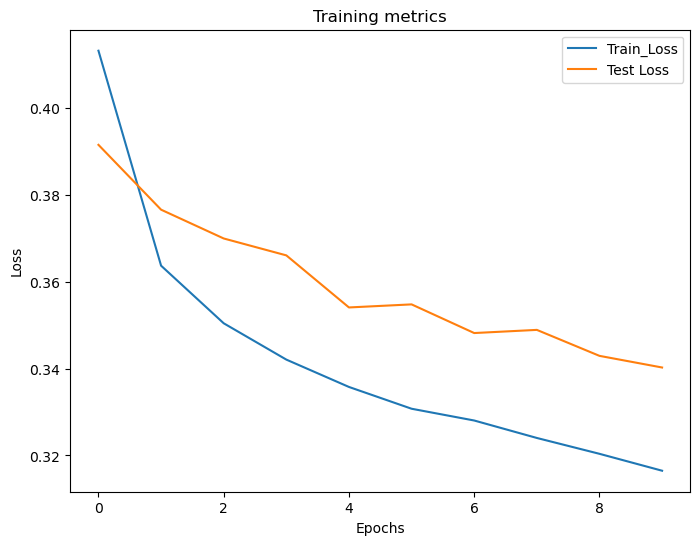

In [9]:
best_r2, history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, test_loader)
plot_loss_function(history['train_loss'], history['test_loss'], 'baseline')

In [10]:
print(history['r2'][-1])

0.6569041013717651


# Feature Selection

In [11]:
X_test_combined = np.hstack([X_test_text, X_test_tab])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model.to(device)

MultimodalRegressor(
  (text_encoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (tab_encoder): Sequential(
    (0): Linear(in_features=45, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fusion): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [14]:
X_test_text_tensor = X_test_text.clone().detach().requires_grad_(True)
X_test_tab_tensor  = X_test_tab.clone().detach().requires_grad_(True)
y_test_tensor      = y_test.clone().detach()
X_test_text_tensor = X_test_text_tensor.to(device)
X_test_tab_tensor  = X_test_tab_tensor.to(device)
y_test_tensor      = y_test_tensor.to(device)

In [15]:
ig = IntegratedGradients(model)

In [16]:
batch_size = 64
attr_text_list = []
attr_tab_list = []

for i in range(0, X_test_text_tensor.shape[0], batch_size):
    X_text_batch = X_test_text_tensor[i:i+batch_size].to(device)
    X_tab_batch  = X_test_tab_tensor[i:i+batch_size].to(device)

    attr_text_batch, attr_tab_batch = ig.attribute(
        inputs=(X_text_batch, X_tab_batch),
        target=0,
        n_steps=20,
        return_convergence_delta=False
    )
    attr_text_list.append(attr_text_batch.detach().cpu())
    attr_tab_list.append(attr_tab_batch.detach().cpu())

attr_text = torch.cat(attr_text_list, dim=0)
attr_tab = torch.cat(attr_tab_list, dim=0)

In [17]:
text_feature_names = [f"text_{i}" for i in range(X_train_text.shape[1])]
tab_feature_names = list((train.drop(columns=['SalaryNormalized'])).columns)
all_feature_names = text_feature_names + tab_feature_names

In [18]:
attr_text_mean = attr_text.abs().mean(dim=0).detach().numpy()
attr_tab_mean = attr_tab.abs().mean(dim=0).detach().numpy()

feature_names = list(text_feature_names) + list(tab_feature_names)
importances = np.concatenate([attr_text_mean, attr_tab_mean])

In [19]:
print("all features: ", len(feature_names))

all features:  95


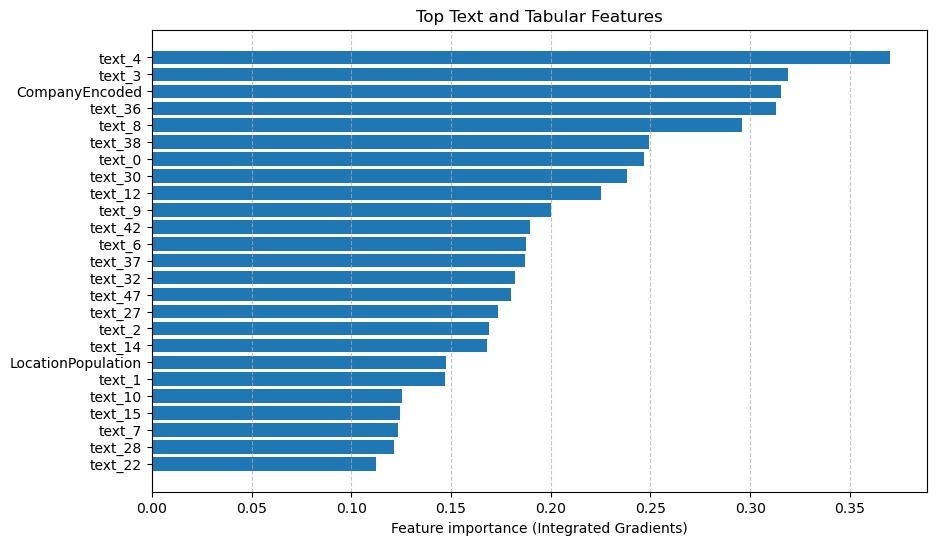

In [20]:
top_k = 25
sorted_idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature importance (Integrated Gradients)")
plt.title("Top Text and Tabular Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('TopTabularAndTextFeatures.png')
plt.show()
plt.close()

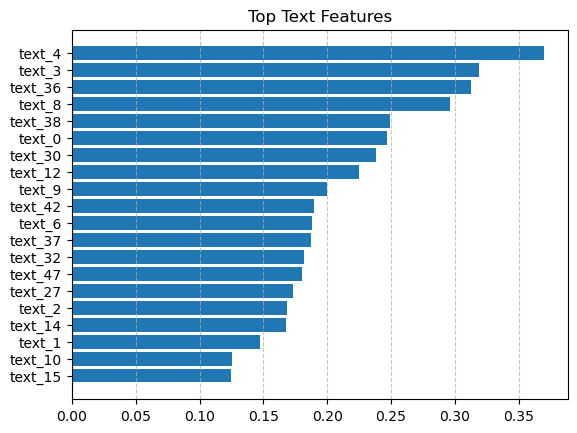

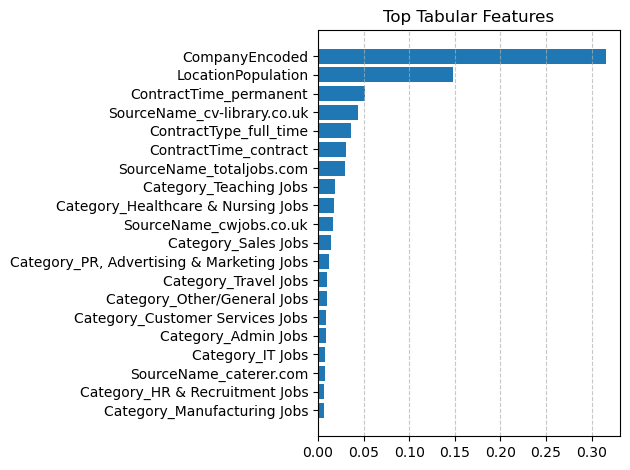

In [21]:
# text
sorted_idx_text = np.argsort(attr_text_mean)[::-1][:20]
plt.barh(np.array(text_feature_names)[sorted_idx_text], attr_text_mean[sorted_idx_text])
plt.title("Top Text Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('TopTextFeatures.png')
plt.show()

# tab
sorted_idx_tab = np.argsort(attr_tab_mean)[::-1][:20]
plt.barh(np.array(tab_feature_names)[sorted_idx_tab], attr_tab_mean[sorted_idx_tab])
plt.title("Top Tabular Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('TopTabularFeatures.png')
plt.show()
plt.close()

# Prepare top 25 selected features

In [22]:
selected_cols = np.array(feature_names)[sorted_idx]
selected_idx = [all_feature_names.index(col) for col in selected_cols]

In [23]:
text_idx = [i for i, name in enumerate(text_feature_names) if name in selected_cols]
tab_idx = [i for i, name in enumerate(tab_feature_names) if name in selected_cols]

X_train_text_selected = X_train_text[:, text_idx]
X_test_text_selected  = X_test_text[:, text_idx]

X_train_tab_selected = X_train_tab[:, tab_idx]
X_test_tab_selected  = X_test_tab[:, tab_idx]

print("Selected text features:", X_train_text_selected.shape)
print("Selected tab features:", X_train_tab_selected.shape)

Selected text features: torch.Size([171337, 23])
Selected tab features: torch.Size([171337, 2])


In [24]:
model = MultimodalRegressor(text_dim=X_train_text_selected.shape[1], tab_dim=X_train_tab_selected.shape[1], dropout=0.3)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

# Model comparison

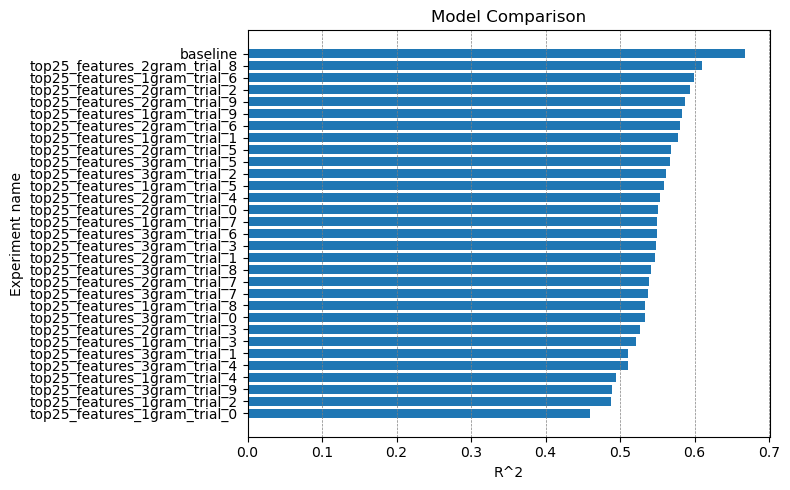

In [29]:
model_comparison()

# Optuna

In [26]:
def create_objective(X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test, exp_path, epochs):
    
    def objective(trial):
        
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.3, 0.6)
        hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        patience = trial.suggest_int("patience", 3, 10)
    
        text_dim = X_train_text.shape[1]
        tab_dim = X_train_tab.shape[1] 
        
        model = MultimodalRegressor(
            text_dim=text_dim, 
            tab_dim=tab_dim, 
            dropout=dropout, 
            hidden_dim=hidden_dim
        )
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_func = nn.MSELoss()
        
        train_loader, test_loader = prepare_dataloaders(
            batch_size, X_train_text, X_train_tab, y_train, 
            X_test_text, X_test_tab, y_test
        )
    
        trial_name = f"trial_{trial.number}"
        results_path = os.path.join(exp_path, trial_name)
        
        best_test_r2, history = train_evaluate(
            model, optimizer, loss_func, epochs=epochs,
            train_loader=train_loader, test_loader=test_loader, 
            results_path=results_path, patience=patience
        )
    
        trial.set_user_attr('history', history)
    
        return best_test_r2
    return objective

In [27]:
# exp_name = 'top25_features'
# exp_path = f'logs/{exp_name}/'

# objective_fn = create_objective(
#     X_train_text = X_train_text_selected,
#     X_train_tab = X_train_tab_selected, 
#     y_train = y_train,
#     X_test_text = X_test_text_selected, 
#     X_test_tab = X_test_tab_selected, 
#     y_test = y_test,
#     exp_path = exp_path,
#     epochs = 30
# )

# study = optuna.create_study(direction="maximize") 
# study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

# print("Best R2:", study.best_value)
# print("Best params:", study.best_params)


# # save best results
# best_trial_info = {
#     "trial_number": study.best_trial.number,
#     "best_r2": study.best_value,
#     "best_params": study.best_params
# }

# os.makedirs(exp_path, exist_ok=True)
# with open(os.path.join(exp_path, 'best_trail.json'), "w", encoding="utf-8") as f:
#     json.dump(best_trial_info, f, indent=4)

# 2-gram

In [ ]:
exp_name = '3gram'
exp_path = f'logs/{exp_name}/'

objective_fn = create_objective(
    X_train_text = X_train_text,
    X_train_tab = X_train_tab, 
    y_train = y_train,
    X_test_text = X_test_text, 
    X_test_tab = X_test_tab, 
    y_test = y_test,
    exp_path = exp_path,
    epochs = 30
)

study = optuna.create_study(direction="maximize") 
study.optimize(objective_fn, n_trials=10, show_progress_bar=True) 

print("Best R2:", round(study.best_value, 3))
print("Best params:", study.best_params)


# save best results
best_trial_info = {
    "trial_number": study.best_trial.number,
    "best_r2": study.best_value,
    "best_params": study.best_params
}

os.makedirs(exp_path, exist_ok=True)
with open(os.path.join(exp_path, 'best_trail.json'), "w", encoding="utf-8") as f:
    json.dump(best_trial_info, f, indent=4)

[I 2025-10-22 09:22:19,071] A new study created in memory with name: no-name-e83ef4da-f4de-4922-98e3-b0fc309fe009


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30 - test_loss: 0.5814
Epoch 2/30 - test_loss: 0.4957
Epoch 3/30 - test_loss: 0.4733
Epoch 4/30 - test_loss: 0.4608
Epoch 5/30 - test_loss: 0.4531
Epoch 6/30 - test_loss: 0.4474
Epoch 7/30 - test_loss: 0.4432
Epoch 8/30 - test_loss: 0.4405
Epoch 9/30 - test_loss: 0.4377
Epoch 10/30 - test_loss: 0.4350
